# Sentiment Analysis of Stock Market News

## Introduction

In the highly volatile world of stock markets, news articles can significantly influence investor sentiment and market movements. Understanding the sentiment conveyed in these articles can provide valuable insights for making informed investment decisions. My project aims to harness the power of natural language processing (NLP) to analyze the sentiment of stock market news articles, classifying them as either positive or negative.

Sentiment analysis, also known as opinion mining, involves using computational techniques to determine the emotional tone behind words. In this project, I develop a sentiment analysis model that processes news articles related to the stock market and classifies the sentiment of each article. By doing so, I aim to provide investors and analysts with a tool to gauge the overall market sentiment, potentially identifying trends and making more informed decisions.

To achieve this, I employ various techniques and tools:
- **Data Preprocessing**: I clean and preprocess the textual data to remove noise and irrelevant information, ensuring the data is in a suitable format for analysis.
- **Exploratory Data Analysis (EDA)**: Through visualizations and statistical analysis, I explore the dataset to understand the distribution of sentiments, text lengths, and common words or phrases.
- **Feature Extraction with GloVe Embeddings**: I use Global Vectors for Word Representation (GloVe) to convert words into numerical vectors that capture their semantic meaning, enhancing the model's ability to understand context.
- **Neural Network Modeling**: Leveraging TensorFlow and Keras, I build a robust neural network model that includes layers such as bidirectional LSTM to capture the sequential nature of text data.
- **Model Evaluation**: I assess the model's performance using various metrics and visualizations, such as accuracy, ROC curves, and confusion matrices, to ensure its effectiveness in sentiment classification.

By the end of this project, I aim to deliver a well-tuned sentiment analysis model capable of accurately classifying the sentiment of stock market news articles. This tool can be instrumental for investors, financial analysts, and anyone interested in understanding the market's reaction to news events. The insights derived from this model can aid in identifying bullish or bearish trends, ultimately contributing to more strategic investent decisions.
ent decisions.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import random
import seaborn as sns
import requests
import zipfile
import os

nltk.download('stopwords')

print("Tensorflow Version", tf.__version__)


Tensorflow Version 2.16.1


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MayCooperStation\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Label Decoding and Distribution Plot
This section decodes the numerical sentiment labels into categorical labels ('Positive' and 'Negative'). The `label_decoder` function maps the values "-1" and "1" to "Negative" and "Positive," respectively. 

A bar plot is created to visualize the distribution of sentiment labels in the dataset, showing how many instances of each sentiment are present. This gives a quick overview of the dataset's balance between positive and negative sentiments.


In [2]:
# Load the dataset
df = pd.read_csv('stock_data.csv', encoding='latin', header=None)
df1 = df.iloc[1:]
df.drop(index=df.index[0], axis=0, inplace=True)
df.columns = ['text', 'sentiment']

# Label decoding
lab_to_sentiment = {"-1": "Negative", "1": "Positive"}
def label_decoder(label):
    y = lab_to_sentiment.get(label)
    if y is not None:
        return y
    else:
        return "Unknown"

df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))

# Display first few rows
df.head()


,text,sentiment
1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,Positive
2,user: AAP MOVIE. 55% return for the FEA/GEED i...,Positive
3,user I'd be afraid to short AMZN - they are lo...,Positive
4,MNTA Over 12.00,Positive
5,OI Over 21.37,Positive


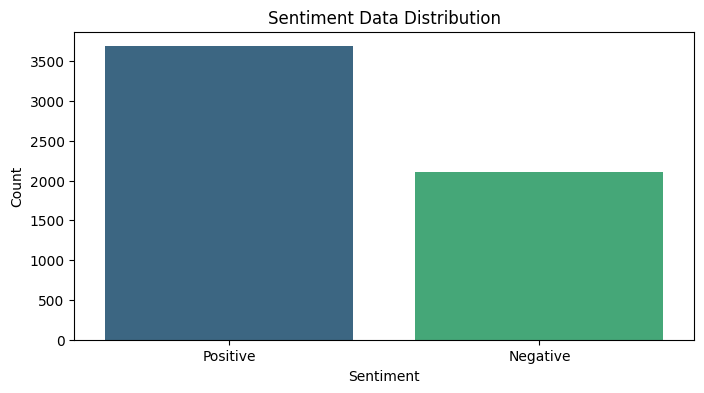

,text,sentiment,text_length,word_count
2607,hpq nvda qcom umored hp tablet could use tegra...,Positive,13,13
4631,today watchlist ong stocks jaso ziop vhc snfca...,Positive,11,11
2826,swy option bears buy puts betting 500k 10 move,Negative,9,9
1867,dk 34 75 continuation,Positive,4,4
3167,ami taking,Positive,2,2
3167,ami taking,Positive,2,2
712,triple bottoms rare third time aap traded near...,Negative,17,17
3509,nan like daily intraday setup try 18 80,Positive,8,8
1573,goog deciding strike buy close calls aap flagg...,Positive,10,10
2447,side note nelson peltz trian actually designed...,Positive,16,16


In [54]:
# Sentiment data distribution plot
val_count = df.sentiment.value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=val_count.index, y=val_count.values, hue=val_count.index, palette="viridis", dodge=False, legend=False)
plt.title("Sentiment Data Distribution")
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Display random samples
random_idx_list = [random.randint(1, len(df.text)) for _ in range(10)]
df.loc[random_idx_list, :].head(10)

### Preprocessing Function and Random Samples Display
The text data is cleaned using the `preprocess` function, which removes special characters, URLs, and stopwords. It also optionally applies stemming to reduce words to their root forms.

The cleaned text data is displayed by showing 10 random samples from the dataset. This step ensures that the preprocessing function works correctly and that the text data is in a suitable format for further analysis and modeling.


In [4]:
# Define stopwords and stemmer
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Preprocessing function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

# Display first few rows after preprocessing
df.head()


,text,sentiment
1,kickers watchlist xide tit soq pnk cpw bpz aj ...,Positive
2,user aap movie 55 return fea geed indicator 15...,Positive
3,user afraid short amzn looking like near monop...,Positive
4,mnta 12 00,Positive
5,oi 21 37,Positive


### Text Length Distribution and Sentiment Count Plot
This section calculates the length of each text entry by counting the number of words. It then plots the distribution of text lengths using a histogram, providing insight into the typical length of text entries in the dataset.

A count plot is also created to show the number of positive and negative sentiment entries. This visualization helps in understanding the balance of the dataset and identifying any potential class imbalance issues.


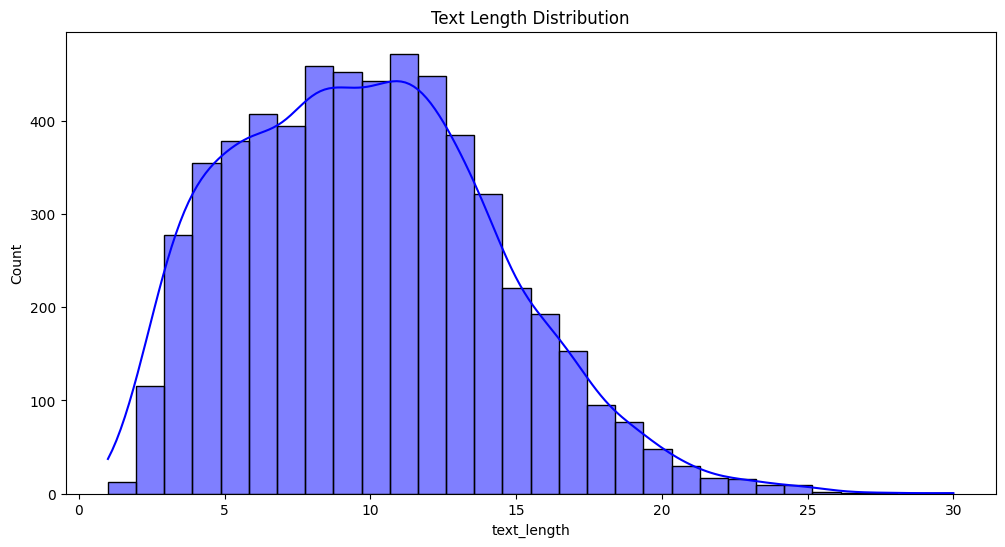

In [5]:
# Plot text length distribution
df['text_length'] = df.text.apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], kde=True, bins=30, color='blue')
plt.title("Text Length Distribution")
plt.show()


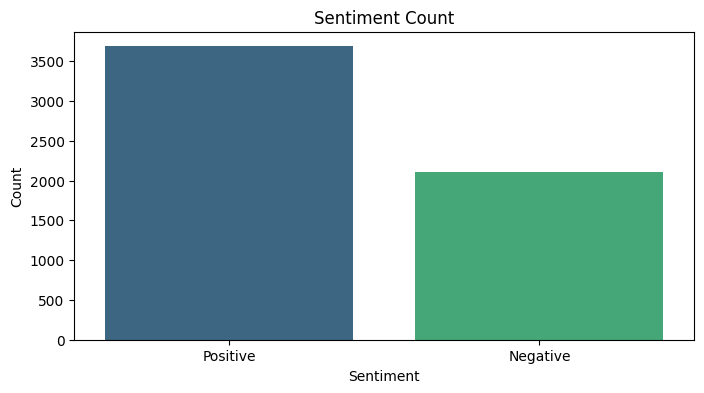

In [28]:
# Plot the count of each sentiment
plt.figure(figsize=(8, 4))
sns.countplot(x='sentiment', data=df, hue='sentiment', palette='viridis', dodge=False, legend=False)
plt.title('Sentiment Count')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

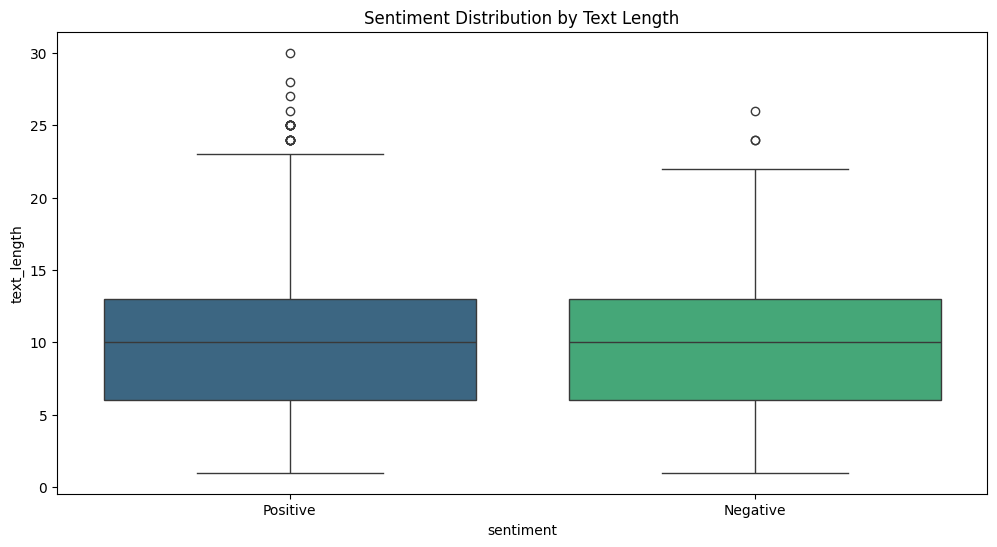

In [18]:
# Plot sentiment distribution by text length
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='text_length', data=df, hue='sentiment', palette="viridis", legend=False)
plt.title("Sentiment Distribution by Text Length")
plt.show()


### Most Common Words
This section defines a function to identify and plot the most common words in the text data for each sentiment category. The `plot_most_common_words` function uses the `Counter` class to count word frequencies and generates a bar plot for the top 20 most common words.

By visualizing the most common words, we can gain insights into the vocabulary and themes prevalent in positive and negative sentiments, which can inform feature selection and model interpretation.


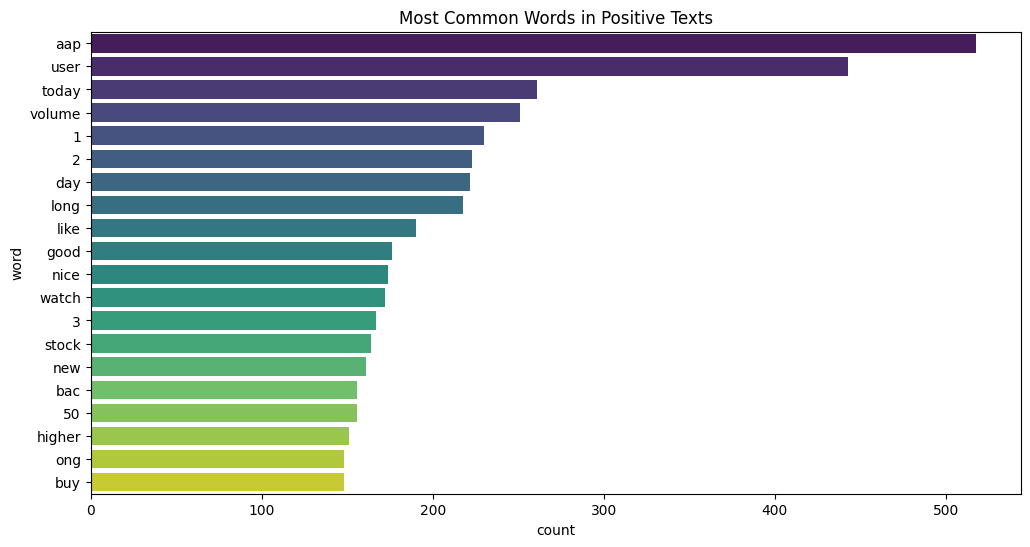

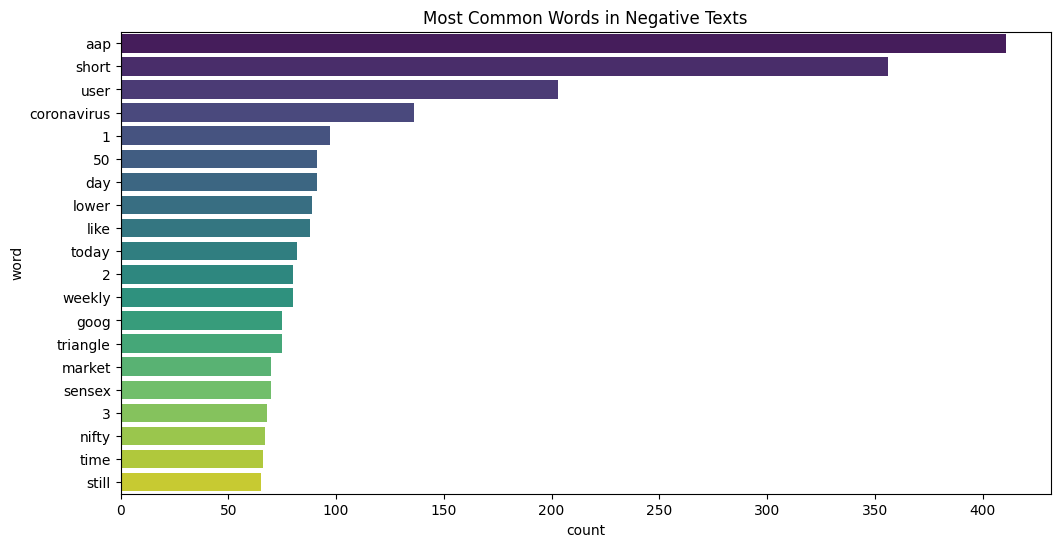

In [21]:
from collections import Counter

# Function to plot the most common words
def plot_most_common_words(text, sentiment):
    words = ' '.join(text).split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(20)
    
    df_common_words = pd.DataFrame(common_words, columns=['word', 'count'])
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='count', y='word', hue='word', dodge=False, data=df_common_words, palette='viridis', legend=False)
    plt.title(f'Most Common Words in {sentiment} Texts')
    plt.show()

# Plot most common words for positive texts
plot_most_common_words(df[df.sentiment == 'Positive'].text, 'Positive')

# Plot most common words for negative texts
plot_most_common_words(df[df.sentiment == 'Negative'].text, 'Negative')


### Top N-Grams
This section defines a function to plot the most common unigrams (single words), bigrams (two-word combinations), and trigrams (three-word combinations) in the text data. 

Using `CountVectorizer`, the function extracts n-grams and generates bar plots for the most frequent n-grams. Analyzing n-grams helps in understanding common phrases and word combinations, providing deeper insights into the text data and potentially improving model performance.


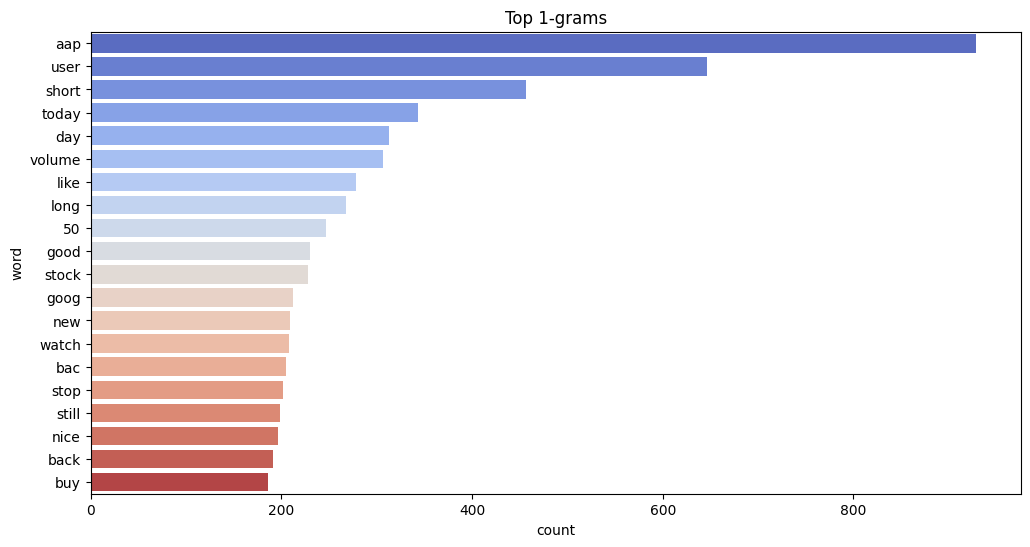

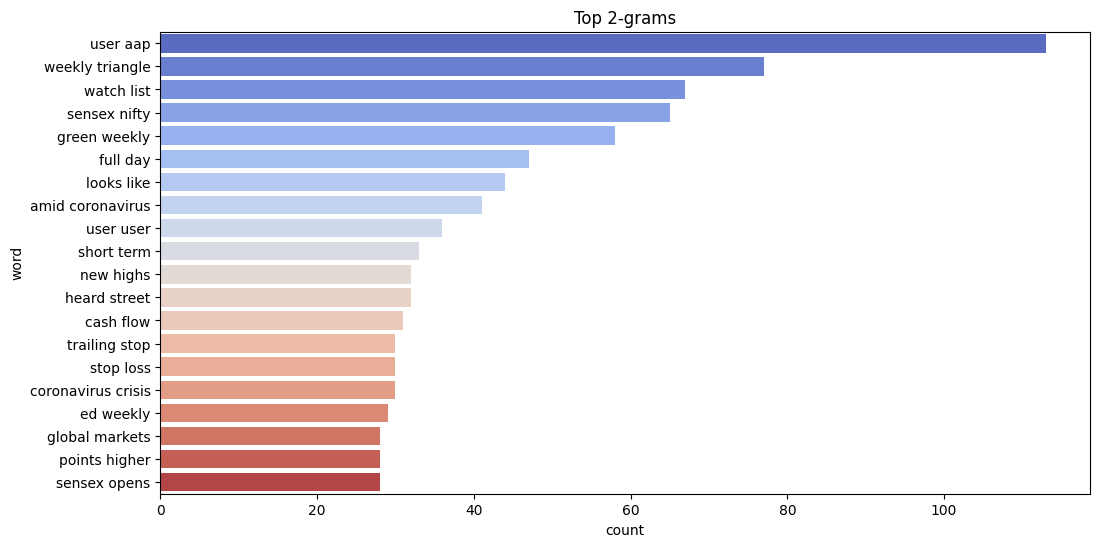

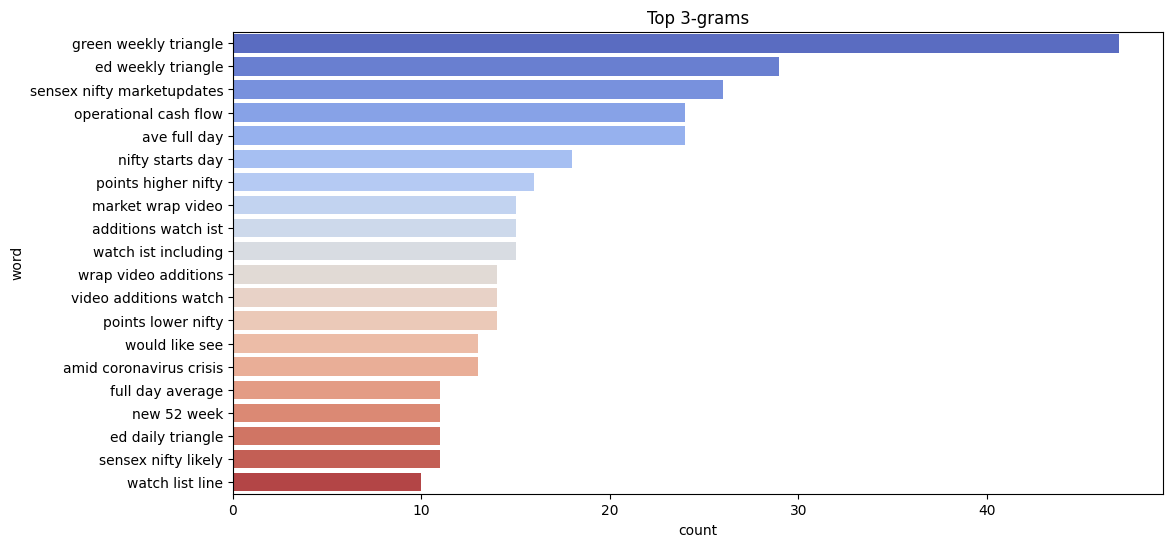

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to plot top n-grams
def plot_top_ngrams(text, n, title):
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    df_ngrams = pd.DataFrame(words_freq[:20], columns=['word', 'count'])
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='count', y='word', hue='word', dodge=False, data=df_ngrams, palette='coolwarm', legend=False)
    plt.title(f'Top {n}-grams')
    plt.show()

# Plot top unigrams (1-grams)
plot_top_ngrams(df.text, 1, 'Top Unigrams')

# Plot top bigrams (2-grams)
plot_top_ngrams(df.text, 2, 'Top Bigrams')

# Plot top trigrams (3-grams)
plot_top_ngrams(df.text, 3, 'Top Trigrams')


### Text Length Distribution by Sentiment
This section visualizes the distribution of text lengths for each sentiment category using a histogram. The plot helps to compare the text length distributions between positive and negative sentiments, revealing any differences in text length patterns across sentiments.


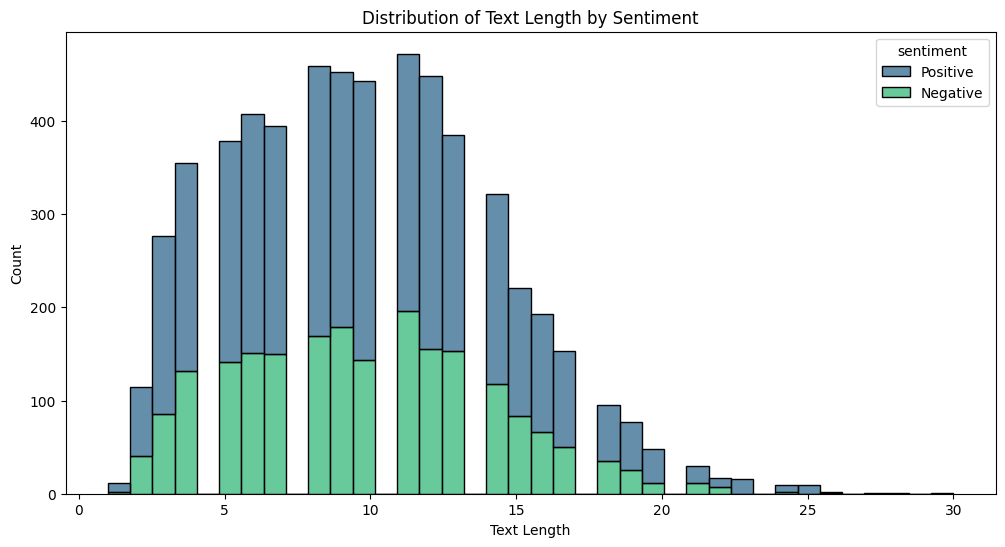

In [31]:
# Distribution of text length by sentiment
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='sentiment', multiple='stack', palette='viridis')
plt.title('Distribution of Text Length by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

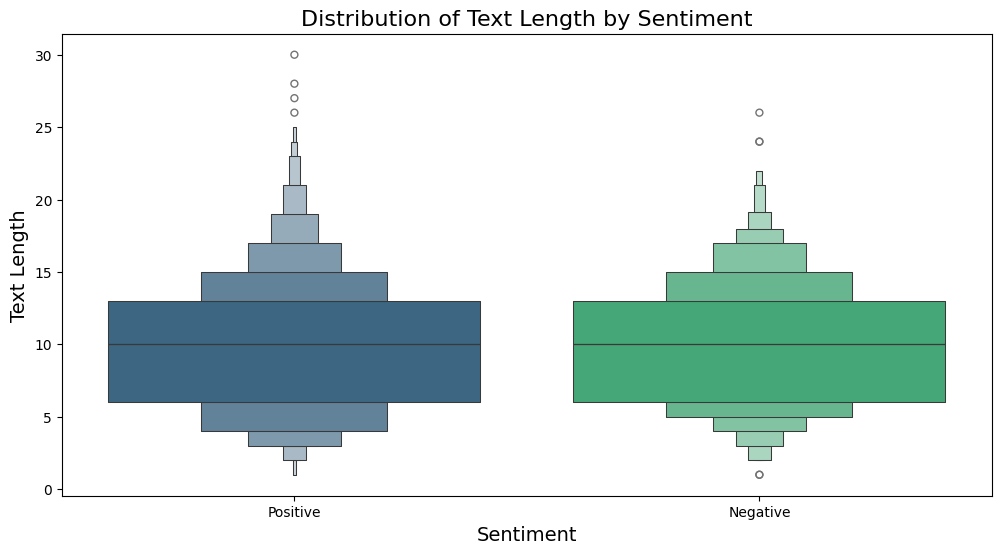

In [48]:
# Boxen plot of text length by sentiment
plt.figure(figsize=(12, 6))
sns.boxenplot(x='sentiment', y='text_length', hue='sentiment', palette='viridis', dodge=False, legend=False, data=df)
plt.title('Distribution of Text Length by Sentiment', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Text Length', fontsize=14)
plt.show()

### Train-Test Split and Tokenization
This section splits the dataset into training and testing sets using an 80-20 split. It then tokenizes the text data, converting words into numerical indices, and pads the sequences to ensure uniform length.

Tokenization is a crucial step in preparing text data for neural network models, as it transforms the text into a format that can be processed by the model. Padding ensures that all input sequences have the same length, which is necessary for batch processing in neural networks.


In [6]:
TRAIN_SIZE = 0.8
MAX_SEQUENCE_LENGTH = 30

# Split the data
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=7)
print("Train Data size:", len(train_data))
print("Test Data size:", len(test_data))

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size:", vocab_size)

# Pad the sequences
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen=MAX_SEQUENCE_LENGTH)

print("Training X Shape:", x_train.shape)
print("Testing X Shape:", x_test.shape)

# Encode the labels
labels = train_data.sentiment.unique().tolist()
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Train Data size: 4632
Test Data size: 1159
Vocabulary Size: 7947
Training X Shape: (4632, 30)
Testing X Shape: (1159, 30)
y_train shape: (4632, 1)
y_test shape: (1159, 1)


### Loading GloVe Embeddings
This section downloads pre-trained GloVe word embeddings and loads them into a dictionary. GloVe embeddings capture semantic relationships between words, providing rich word representations that improve model performance.

The code then creates an embedding matrix where each row corresponds to a word's embedding vector. This matrix is used to initialize the embedding layer in the neural network, allowing the model to leverage the pre-trained word vectors.


In [7]:
# # Path to save the GloVe zip file
# zip_path = os.path.join("Documents", "Deep Learning", "NLP", "stocks", "glove.6B.zip")
# extracted_path = os.path.join("Documents", "Deep Learning", "NLP", "stocks")

# # URL of the GloVe embeddings
# url = "http://nlp.stanford.edu/data/glove.6B.zip"

# # Create directories if they don't exist
# os.makedirs(extracted_path, exist_ok=True)

# # Download the file
# response = requests.get(url, stream=True)
# with open(zip_path, "wb") as f:
#     for chunk in response.iter_content(chunk_size=128):
#         f.write(chunk)

# # Unzip the file
# with zipfile.ZipFile(zip_path, "r") as zip_ref:
#     zip_ref.extractall(extracted_path)

# # Path to the extracted GloVe file
# GLOVE_EMB = os.path.join(extracted_path, "glove.6B.300d.txt")
# if not os.path.exists(GLOVE_EMB):
#     raise FileNotFoundError(f"File not found: {GLOVE_EMB}")

# # Load the GloVe embeddings
# embeddings_index = {}

# with open(GLOVE_EMB, 'r', encoding='utf-8') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs

# print('Found %s word vectors.' % len(embeddings_index))

# # Create the embedding matrix
# EMBEDDING_DIM = 300
# embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

# # Create the embedding layer
# embedding_layer = tf.keras.layers.Embedding(vocab_size,
#                                             EMBEDDING_DIM,
#                                             weights=[embedding_matrix],
#                                             trainable=False)


Found 400000 word vectors.


### Define and Compile the Model
This section defines a neural network model using TensorFlow and Keras. The model includes an embedding layer, a bidirectional LSTM layer, and several dense layers. The architecture is designed to capture sequential dependencies and complex patterns in the text data.

The model is compiled with the Adam optimizer and binary crossentropy loss function. The Adam optimizer is chosen for its efficiency and adaptive learning rate, while binary crossentropy is appropriate for binary classification tasks.


In [8]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define additional parameters
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

# Define the model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(factor=0.1, min_lr=0.01, monitor='val_loss', verbose=1)

# Train the model
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[reduce_lr])


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on CPU...
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.6044 - loss: 0.6749 - val_accuracy: 0.6428 - val_loss: 0.6431 - learning_rate: 0.0010
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6379 - loss: 0.6445 - val_accuracy: 0.6462 - val_loss: 0.6294 - learning_rate: 0.0010
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.6371 - loss: 0.6230 - val_accuracy: 0.6764 - val_loss: 0.6033 - learning_rate: 0.0010
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6907 - loss: 0.5861 - val_accuracy: 0.6851 - val_loss: 0.5942 - learning_rate: 0.0010
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.7058 - loss: 0.5647 - val_accuracy: 0.7041 - val_loss: 0.5819 - learning_rate: 0.0010
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.7396 - loss: 0.5335 - val_accuracy: 0.7032 - val_loss: 0.5701 - learning_rate: 0.0010


### Model Evaluation
This section evaluates the model's performance on the test data. It includes generating a classification report, which provides precision, recall, f1-score, and support for each class.

The confusion matrix is computed and plotted to show the number of true positive, true negative, false positive, and false negative predictions. This helps in understanding the model's classification errors and overall performance.


In [52]:
# Print classification report
print(classification_report(y_test, [1 if score > 0.5 else 0 for score in scores], target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.61      0.59      0.60       414
    Positive       0.78      0.79      0.78       745

    accuracy                           0.72      1159
   macro avg       0.69      0.69      0.69      1159
weighted avg       0.72      0.72      0.72      1159



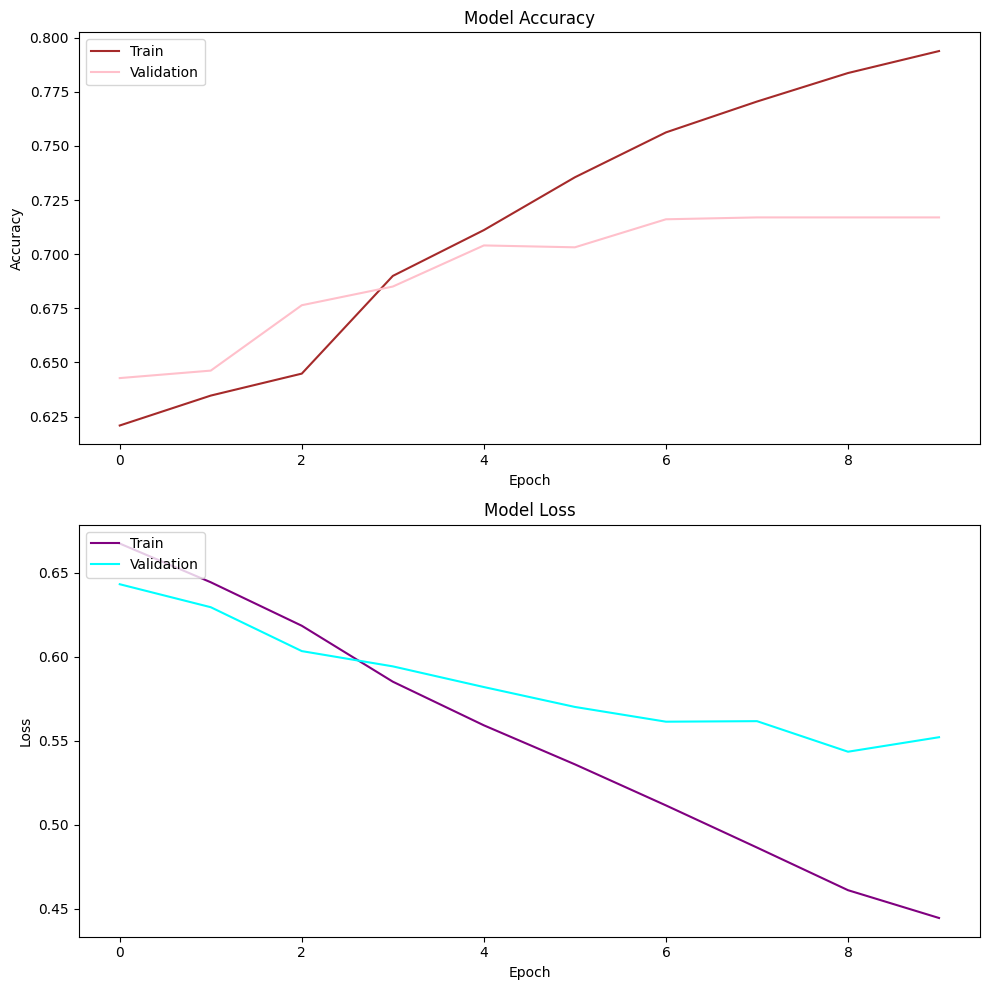

In [9]:
# Plot training history
s, (at, al) = plt.subplots(2, 1, figsize=(10, 10))
at.plot(history.history['accuracy'], c='brown')
at.plot(history.history['val_accuracy'], c='pink')
at.set_title('Model Accuracy')
at.set_ylabel('Accuracy')
at.set_xlabel('Epoch')
at.legend(['Train', 'Validation'], loc='upper left')

al.plot(history.history['loss'], c='purple')
al.plot(history.history['val_loss'], c='cyan')
al.set_title('Model Loss')
al.set_ylabel('Loss')
al.set_xlabel('Epoch')
al.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


### Confusion Matrix
This section evaluates the model's performance using a confusion matrix, which provides insights into the accuracy of the predictions.

#### Explanation of the Specific Result
The confusion matrix for this model is shown in the plot below. It illustrates the model's performance in classifying the positive and negative sentiments:

- **True Positive (TP)**: 59% of positive sentiments were correctly classified as positive.
- **False Positive (FP)**: 41% of positive sentiments were incorrectly classified as negative.
- **True Negative (TN)**: 79% of negative sentiments were correctly classified as negative.
- **False Negative (FN)**: 21% of negative sentiments were incorrectly classified as positive.

The diagonal values (0.59 and 0.79) represent the proportion of correct classifications for positive and negative sentiments, respectively. The off-diagonal values (0.41 and 0.21) represent the proportion of incorrect classifications.

Overall, the model shows a higher accuracy in correctly classifying negative sentiments (79%) compared to positive sentiments (59%). This indicates that while the model is relatively good at identifying negative sentiments, there is room for improvement in identifying positive sentiments.

![Confusion Matrix](attachment:image.png)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


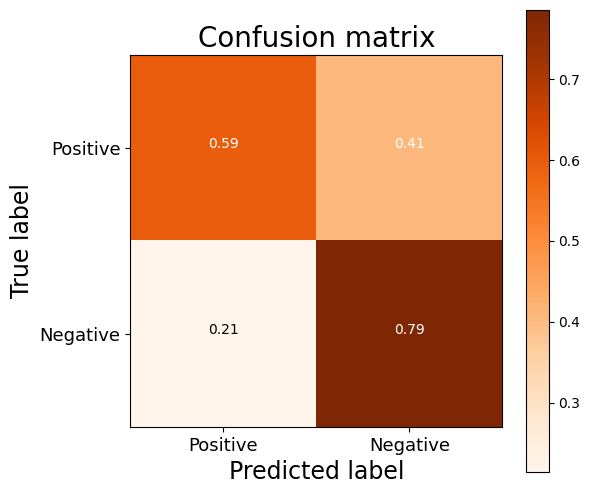

In [10]:
# Decode sentiment function
def decode_sentiment(score):
    return "Positive" if score > 0.5 else "Negative"

# Predict and decode sentiment
scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Oranges):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

# Compute and plot confusion matrix
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()


### ROC Curve
This section computes and plots the Receiver Operating Characteristic (ROC) curve. The ROC curve shows the trade-off between sensitivity (true positive rate) and specificity (false positive rate) for the binary classifier. The area under the curve (AUC) is also computed, providing a single metric to summarize the model's performance.

#### Explanation of the Specific Result
The ROC curve for this model is shown in the plot above. The orange line represents the ROC curve, and the blue dashed line represents the baseline performance (random guessing) with an AUC of 0.5.

- **True Positive Rate (Sensitivity)**: This is plotted on the y-axis and indicates the proportion of actual positives correctly identified by the model.
- **False Positive Rate**: This is plotted on the x-axis and indicates the proportion of actual negatives incorrectly identified as positives by the model.

The area under the ROC curve (AUC) is 0.78. This AUC value indicates that the model has a good ability to distinguish between the positive and negative classes. An AUC of 0.78 means that there is a 78% chance that the model will correctly distinguish a randomly chosen positive instance from a randomly chosen negative instance.

In general, an AUC value:
- Close to 1.0 indicates excellent performance.
- Between 0.7 and 0.8 indicates good performance.
- Between 0.6 and 0.7 indicates moderate performance.
- Close to 0.5 indicates poor performance, no better than random guessing.

The ROC curve and AUC value suggest that the model is performing well in distinguishing between positive and negative sentiments n the test data.


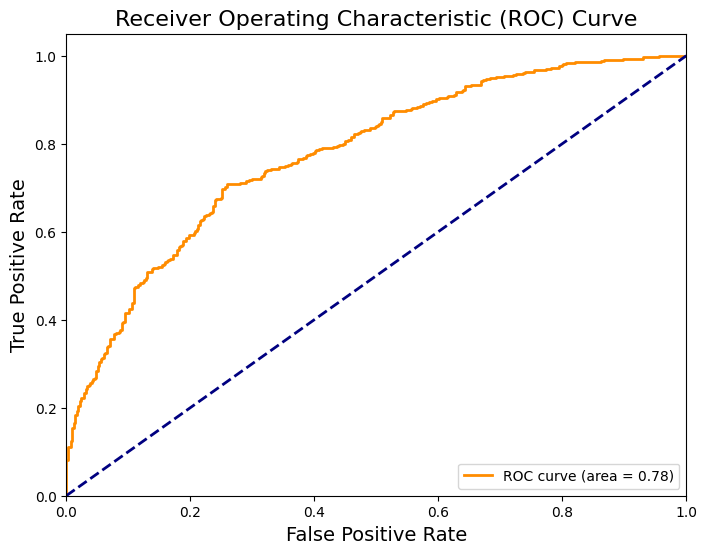

In [49]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.show()

### Precision-Recall Curve
This section computes and plots the Precision-Recall (PR) curve to evaluate the model's performance.

#### Explanation of the Specific Result
The Precision-Recall curve for this model is shown in the plot below. The blue line represents the PR curve, plotting Precision (y-axis) against Recall (x-axis). The area under the curve (AP) is 0.86.

- **Precision**: True positive predictions / Total positive predictions.
- **Recall**: True positive predictions / Total actual positives.

An AP of 0.86 indicates that the model maintains a good balance between precision and recall, effectively distinguishing between positive and negative sentiments.ion and recall.


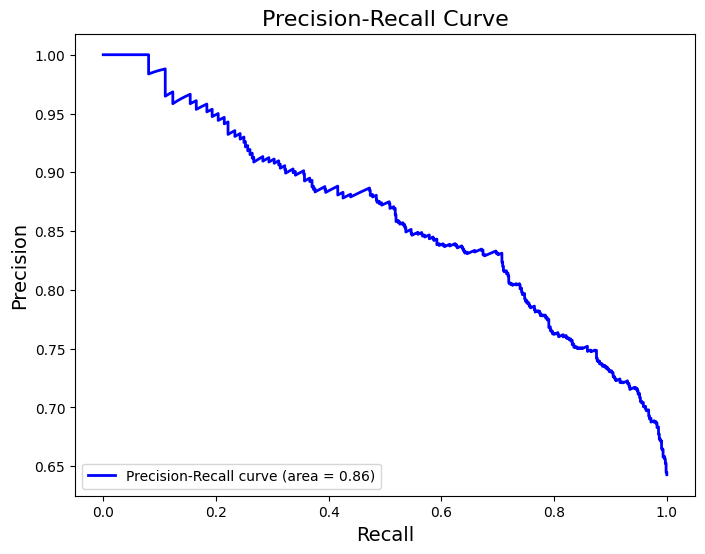

In [50]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, scores)
average_precision = average_precision_score(y_test, scores)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {average_precision:0.2f})')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc="lower left")
plt.show()

### Distribution of Predicted Probabilities
This section plots the distribution of predicted probabilities for the positive class. The histogram provides a visual representation of the model's confidence in its predictions, showing how the probabilities are distributed across the test set.


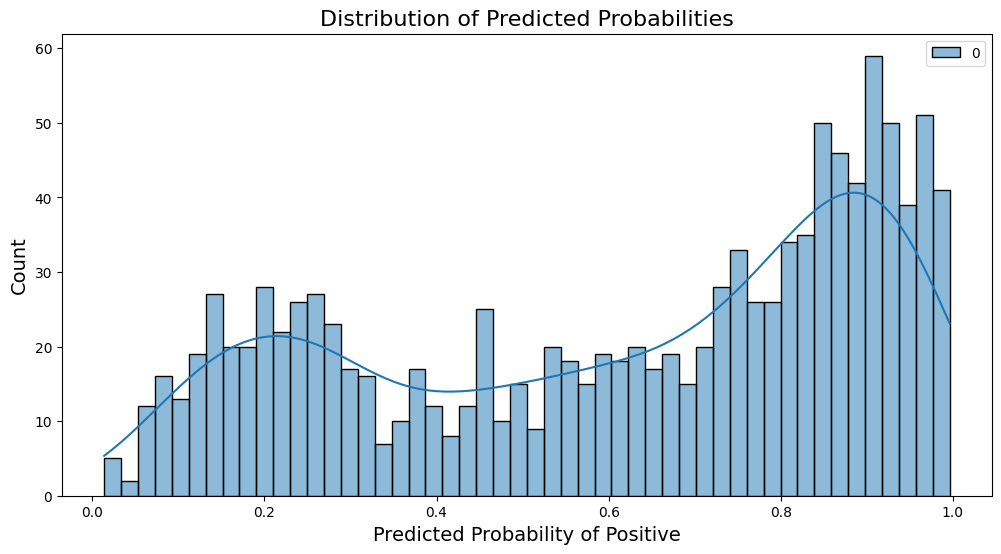

In [53]:
# Plot distribution of predicted probabilities
plt.figure(figsize=(12, 6))
sns.histplot(scores, bins=50, color='purple', kde=True)
plt.title('Distribution of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability of Positive', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()